In [1]:
# Importación de librerías standar de python
import pandas as pd
import html
import numpy as np
import os, sys
from sqlalchemy import create_engine

# importación de librerías propias
import utils.folders_tb as fold 
import utils.mining_data_tb as md 
import matplotlib.pyplot as plt
from utils.jsons import read_json_to_dict
from utils.mysql_driver import MySQL
import utils.mysql_driver as drv




In [2]:
# Lectura de los archivos con los datos en bruto y unión y refinado de las tablas para obtener la tabla final con la que se va a trabajar
mad_votos = fold.read_Votos_Mad()
mad_locales = fold.read_Loc_Mad()
df_mad = md.filter_mad_votos (mad_votos, mad_locales)
df_mad

C:\Users\barke\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,id_barrio,Distritos,Barrios,Locales,Locscenso,Censo-2021,Censo-2019,D-Censo,censo,Abstención-2021,...,PODEMOS-IU-2021,PODEMOS-IU-2019,D-PODEMOS-IU,VarPiU,VarPiUcenso,Cs-2021,Cs-2019,D-Cs,VarCs,VarCscenso
0,11,Centro,Palacio,671,0.038510,17424,17453,-29,17,4160,...,1521,827,694,83.917775,3.983012,435,1696,-1261,-74.351415,-7.237144
1,12,Centro,Embajadores,600,0.019646,30540,30596,-56,30,8812,...,3835,2335,1500,64.239829,4.911591,575,2145,-1570,-73.193473,-5.140799
2,13,Centro,Cortes,519,0.069786,7437,7518,-81,7,1795,...,494,357,137,38.375350,1.842141,205,791,-586,-74.083439,-7.879521
3,14,Centro,Justicia,567,0.044432,12761,12511,250,12,3283,...,665,358,307,85.754190,2.405768,414,1575,-1161,-73.714286,-9.098033
4,15,Centro,Universidad,721,0.030783,23422,23188,234,23,6200,...,1911,1024,887,86.621094,3.787038,634,2390,-1756,-73.472803,-7.497225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,211,Barajas,Alameda de Osuna,74,0.004911,15067,14990,77,15,2296,...,626,424,202,47.641509,1.340678,658,2845,-2187,-76.871705,-14.515166
127,212,Barajas,Aeropuerto,131,0.106331,1232,1231,1,1,499,...,54,37,17,45.945946,1.379870,16,127,-111,-87.401575,-9.009740
128,213,Barajas,Casco Histórico de Barajas,102,0.019148,5327,5425,-98,5,1469,...,275,192,83,43.229167,1.558100,103,645,-542,-84.031008,-10.174582
129,214,Barajas,Timón,66,0.007190,9179,8653,526,9,2025,...,433,292,141,48.287671,1.536115,358,1597,-1239,-77.582968,-13.498202


In [8]:
# SQL
# lectura de los datos de conexión a la base de datos y generación de las variables para conectarse
json_readed = read_json_to_dict("utils" + os.sep + "sql_settings.json")
IP_DNS = json_readed["IP_DNS"]
USER = json_readed["USER"]
PASSWORD = json_readed["PASSWORD"]
BD_NAME = json_readed["BD_NAME"]
PORT = json_readed["PORT"]

# generación de la instancia de BDD y lanzamiento de conexión
mysql_db = MySQL(IP_DNS=IP_DNS, USER=USER, PASSWORD=PASSWORD, BD_NAME=BD_NAME, PORT=PORT)
mysql_db.connect()

# se generan los elementos necesarios para crear la tabla de la base de datos
valores = df_mad.dtypes

sql_create_columns = ""
for i in range(len(valores)):
    row = drv.replace_guion(valores.index[i].upper()) + ' ' + drv.define_SQL_type(str(valores.values[i])) + ' NOT NULL,'
    sql_create_columns += row

# Create table as per requirement
# Erase table if exiting already 
mysql_db.execute_interactive_sql(sql="DROP TABLE IF EXISTS miguel_barquero_delpozo")

# Create the table to hold the data from the data set
# Create the table with the columns automatically
create_table_sql = f"""CREATE TABLE miguel_barquero_delpozo(
    ID INT(11) NOT NULL AUTO_INCREMENT,
    MOMENTO TIMESTAMP NOT NULL,
    {sql_create_columns}
    PRIMARY KEY (ID))"""

mysql_db.execute_interactive_sql(sql=create_table_sql)

# create the loop to insert automatically all the rows in the dataframe
sql_insert_columns = ""
for i in range(len(valores)):
    row =',' +  drv.replace_guion(valores.index[i].upper())
    sql_insert_columns += row

for i in range (len (df_mad)):
    values_list = df_mad.iloc[i].to_list()
    sql_insert_values = ""
    for elem in values_list:
        sql_insert_values += ", '" + str(elem) + "'"

    insert_row_sql = f"""INSERT INTO miguel_barquero_delpozo 
    (MOMENTO{sql_insert_columns})
                VALUES 
    (NOW(){sql_insert_values})"""

    mysql_db.execute_interactive_sql(sql=insert_row_sql)

Connected to MySQL server [05290575t_ds_april_2021_db]
Executed 

DROP TABLE IF EXISTS EDA_MAD

 successfully
Executed 

CREATE TABLE EDA_MAD(
    ID INT(11) NOT NULL AUTO_INCREMENT,
    MOMENTO TIMESTAMP NOT NULL,
    ID_BARRIO INT NOT NULL,DISTRITOS VARCHAR(255) NOT NULL,BARRIOS VARCHAR(255) NOT NULL,LOCALES INT NOT NULL,LOCSCENSO FLOAT(24) NOT NULL,CENSO_2021 INT NOT NULL,CENSO_2019 INT NOT NULL,D_CENSO INT NOT NULL,CENSO INT NOT NULL,ABSTENCIÓN_2021 INT NOT NULL,ABSTENCIÓN_2019 INT NOT NULL,D_ABS INT NOT NULL,BLANCO_2021 INT NOT NULL,BLANCO_2019 INT NOT NULL,D_BLC INT NOT NULL,NULOS_2021 INT NOT NULL,NULOS_2019 INT NOT NULL,D_NULOS INT NOT NULL,PP_2021 INT NOT NULL,PP_2019 INT NOT NULL,D_PP INT NOT NULL,VARPP FLOAT(24) NOT NULL,VARPPCENSO FLOAT(24) NOT NULL,VARPPLOCALES FLOAT(24) NOT NULL,ANTERIOR VARCHAR(255) NOT NULL,PSOE_2021 INT NOT NULL,PSOE_2019 INT NOT NULL,D_PSOE INT NOT NULL,VARPSOE FLOAT(24) NOT NULL,VARPSOECENSO FLOAT(24) NOT NULL,VOX_2021 INT NOT NULL,VOX_2019 INT NOT N

In [9]:
# Consulta select para confirmar la inserción de los datos en la tabla SQL
db = mysql_db.connect()
df = pd.read_sql("select * from miguel_barquero_delpozo", con=db)
df

Connected to MySQL server [05290575t_ds_april_2021_db]


,ID,MOMENTO,ID_BARRIO,DISTRITOS,BARRIOS,LOCALES,LOCSCENSO,CENSO_2021,CENSO_2019,D_CENSO,...,PODEMOS_IU_2021,PODEMOS_IU_2019,D_PODEMOS_IU,VARPIU,VARPIUCENSO,CS_2021,CS_2019,D_CS,VARCS,VARCSCENSO
0,1,2021-06-01 08:20:19,11,Centro,Palacio,671,0.038510,17424,17453,-29,...,1521,827,694,83.9178,3.983010,435,1696,-1261,-74.3514,-7.23714
1,2,2021-06-01 08:20:20,12,Centro,Embajadores,600,0.019646,30540,30596,-56,...,3835,2335,1500,64.2398,4.911590,575,2145,-1570,-73.1935,-5.14080
2,3,2021-06-01 08:20:20,13,Centro,Cortes,519,0.069786,7437,7518,-81,...,494,357,137,38.3754,1.842140,205,791,-586,-74.0834,-7.87952
3,4,2021-06-01 08:20:20,14,Centro,Justicia,567,0.044432,12761,12511,250,...,665,358,307,85.7542,2.405770,414,1575,-1161,-73.7143,-9.09803
4,5,2021-06-01 08:20:20,15,Centro,Universidad,721,0.030783,23422,23188,234,...,1911,1024,887,86.6211,3.787040,634,2390,-1756,-73.4728,-7.49722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,127,2021-06-01 08:20:43,211,Barajas,Alameda de Osuna,74,0.004911,15067,14990,77,...,626,424,202,47.6415,1.340680,658,2845,-2187,-76.8717,-14.51520
127,128,2021-06-01 08:20:44,212,Barajas,Aeropuerto,131,0.106331,1232,1231,1,...,54,37,17,45.9459,1.379870,16,127,-111,-87.4016,-9.00974
128,129,2021-06-01 08:20:44,213,Barajas,Casco Histórico de Barajas,102,0.019148,5327,5425,-98,...,275,192,83,43.2292,1.558100,103,645,-542,-84.0310,-10.17460
129,130,2021-06-01 08:20:44,214,Barajas,Timón,66,0.007190,9179,8653,526,...,433,292,141,48.2877,1.536120,358,1597,-1239,-77.5830,-13.49820


In [65]:

tiempos_proy = fold.read_tiempos()
tiempos_proy['horas'] = tiempos_proy['Horas'].apply(lambda x: float(x.replace(',','.')))
tiempos_proy['porcen'] = tiempos_proy['Porcentaje'].apply(lambda x: round(float(x.replace(',','.')), 2))
tiempos_proy_cat = tiempos_proy.groupby('Categoría').sum().reset_index()
#tiempos_proy_cat.drop(columns=['Subcategorías'], inplace=True)
tiempos_proy


,Categoría,Subcategoría,Horas,Porcentaje,horas,porcen
0,Búsqueda de datos,Elecciones a la asamblea 2021 y 2019,"3,25","5,65217391304348",3.25,5.65
1,Búsqueda de datos,Hostelería en Madrid,"3,25","5,65217391304348",3.25,5.65
2,Data Wrangling & Mining,Dataframe votos en la CAM,6,"10,4347826086957",6.00,10.43
3,Data Wrangling & Mining,Dataframe actividades en la CAM,"1,5","2,60869565217391",1.50,2.61
4,Data Wrangling & Mining,Dataframe actividades en Madrid metropolitano,"1,5","2,60869565217391",1.50,2.61
5,Data Wrangling & Mining,Dataframe votos en Madrid metropolitano,3,"5,21739130434783",3.00,5.22
6,Documentación,Análisis de requisitos,"0,5","0,869565217391304",0.50,0.87
7,Documentación,Seguimiento del proyecto,1,"1,73913043478261",1.00,1.74
8,Documentación,Memoria,1,"1,73913043478261",1.00,1.74
9,Documentación,Documento de presentación,"3,25","5,65217391304348",3.25,5.65


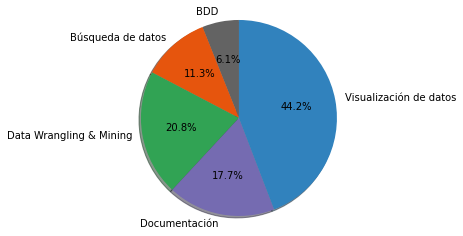

In [66]:

labels = []
percen = []
for i in range(len(tiempos_proy_cat)):
    linea = tiempos_proy_cat.iloc[i].to_list()
    labels.append(linea[0])
    percen.append(linea[2])

cmap = plt.get_cmap("tab20c")
inner_colors = cmap([16,4, 8, 12, 0])
fig1, ax1 = plt.subplots()
ax1.pie(percen, labels=labels, autopct='%1.1f%%', colors= inner_colors,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

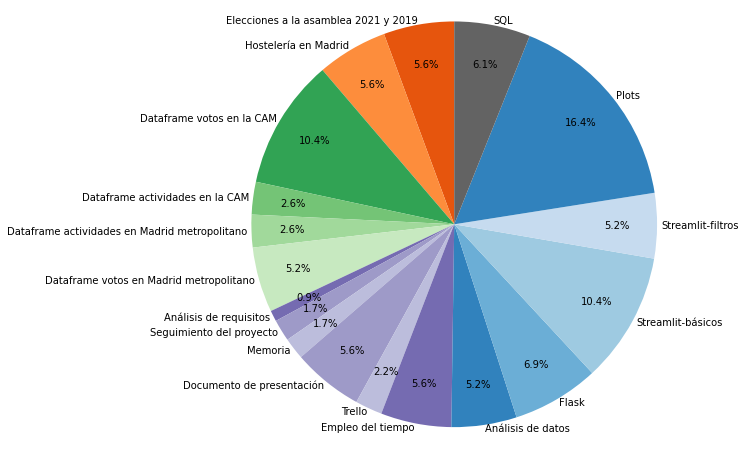

<Figure size 432x288 with 0 Axes>

In [80]:
labels_proy =[]
percen_proy = []
for i in range(len(tiempos_proy)):
    linea = tiempos_proy.iloc[i].to_list()
    labels_proy.append(linea[1])
    percen_proy.append(linea[5])

cmap = plt.get_cmap("tab20c")
inner_colors = cmap([4,5, 8, 9,10,11, 12, 13, 14,13,14, 12, 0, 1,2,3,0, 16])
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(percen_proy, labels=labels_proy, autopct='%1.1f%%', colors= inner_colors, labeldistance=1.02,pctdistance=0.8, shadow=False, startangle=90)
ax1.axis('equal')

plt.show()
plt.savefig('piechart.png')